In [78]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from matplotlib.pyplot import figure
import random
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from pycm import *

## Standardization

Parameter: DataFrame 

Return: Standardized DataFrame

In [2]:
def standardization(df):
    names = df.columns
    scaler = preprocessing.StandardScaler()
    std_df = scaler.fit_transform(df)
    std_df = pd.DataFrame(std_df, columns=names)
    return std_df 

## Preprocessing

parameter: DataFrame of raw data read from csv file.

Return: DataFrame which contain standardized encoded features and non encoded normality column values 

description: This function take dataframe as parameter. Then remove all rows which contain NaN , true ,false ,twenty, non related 
(like org.ds2os.vsl.core.utils.AddressParameters@2c82b391) and none values in value column then change data type of value column from string to float. All columns except value are encoded then all columns except 
normality are standardized and finaly this standardized encoded dataframe is returned along with non encoded normality column 

In [3]:

def Preprocessing(df):
    
    #drop NaN, true, false, twenty, non related and none value rows
    df=df.dropna(axis=0,how='any')
    df=df[np.logical_and(df['value']!='true',df['value']!='false')]
    df=df[np.logical_and(df['value']!='twenty',df['value']!='none')]
    df=df[~df.value.str.contains('org',na=False)]
 
    #change data type of value column to float and make new dataframe without value column to encode

    df=df.astype({'value':float})
    new_df=df.drop(columns=['value'],axis=1)
    
    #encode features to numeric values. X is ndarray of (335479, 11) shape. we take transpose of X to change its shape to (11,335479).
    #now each index contain encoded data of one feature. Now we only run a loop 11 times to store encoded data in encoded_df.

    enc = preprocessing.OrdinalEncoder()
    enc.fit(new_df)
    X=enc.transform(new_df)
    X=np.transpose(X)
    encoded_df=pd.DataFrame(columns=new_df.columns)
    for i in np.arange(X.shape[0]):
            encoded_df.iloc[:,i]=X[i]
    
    # concatenate value column to encoded_df
    encoded_df['value']=df['value'].values
    
    #Now we remove normality column which is a column that contains label and so should not be standardized. Then we standardize all 
    #remaining columns and concatenate again normality column to standardized dataframe.
    
    new_df=encoded_df.drop(columns=['normality'],axis=1)
    std_enc_df=standardization(new_df)
    std_enc_df['normality']=encoded_df['normality'].values
    
    #there is a standard practice to have normal label as 0 and anoumaly as +ve value so we replace value of normal which is 8.0 with 
    #0.0 which is anomalous(DOSattack)
    
    std_enc_df['normality'].loc[std_enc_df['normality'].isin([8.0])]=-1
    std_enc_df['normality'].loc[std_enc_df['normality'].isin([0.0])]=8.0
    std_enc_df['normality'].loc[std_enc_df['normality'].isin([-1.0])]=0
    
    return std_enc_df,df['normality'].values

## Principal Component Analysis

Parameter: ndarray of all feature values and target labels

Return: A Dataframe containing 2 pca components and target label and pca model

Description: PCA reduce dimensionality of data to the number of components given in parameter. For n=2 PCA generate two best features which represent original features.

In [4]:
def pca(features,target):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(features)
    principal_df = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])
    principal_df['target']=target
    return principal_df,pca

## PCA Visualization

Parameter: DataFrame containing principal components with label

Description: As PCA has reduced dimension of data to 2 so it can be visualized on a 2d graph

In [5]:
def pca_visualize(principal_df):
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = np.array(principal_df['target'])
    targets=np.unique(targets)
    for target in targets:
        indicesToKeep = principal_df['target'] == target
        ax.scatter(principal_df.loc[indicesToKeep, 'principal component 1']
           , principal_df.loc[indicesToKeep, 'principal component 2']
           , c = [i%256 for i in np.random.rand(3)]
           , s = 50)
    ax.legend(targets)
    ax.grid()

## Correlation Plot
Parameter: Standardized Encoded Dataframe

Discription: This graph tells us the correlation of every feature with all features. Higher the correlation greater the value in box which means combination of these features is good for classification

In [6]:
def correlation_plot(df):
    corr=df.corr()
    plt.subplots(figsize=(22,12))
    sb.heatmap(corr,annot=True)
    return

## Bi-plot

Parameters: score1 is principal component 1 and principal component 2 values , coeff are principal axes in feature space representing the directions of maximum variance in the data, col_list is a list of all feature names and target is an array of target labels

Discription: bi plot draw 2d pca data with all labels in different colors and direction of maximum variance in data by arrow and name on the arrow head represent feature in that direction

In [7]:
def biplot(score1,coeff,col_list,target):
    figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
    xs = score1.loc[:,'principal component 1']
    ys = score1.loc[:,'principal component 2']
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = target)
 
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, col_list[i], color = 'black', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.legend(target)
   
    plt.grid()
    plt.show()

## Train Test Split

Parameter: x is ndarray of data , y is array of labels and testsize is size of test data

Return: x_train is training data , y_train is training label , x_test is testing data , y_test is testing label

Description: This function split the total data and label into two parts one for training purpose and other for testing purpose based on
testsize given in parameter. if testsize=0.2 then 20% data for testing and 80% for training. 


In [8]:
def split_data(x,y,testsize):	
    x_train,x_test, y_train, y_test =train_test_split( x, y, test_size=testsize,random_state=10, shuffle=True)
    return x_train, x_test, y_train, y_test

## Train Random Forest

Parameter: x_train is training data , y_train is training label

Return: clf is trained classifier

In [9]:
def train_RandomForest(x_train,y_train):
    clf = RandomForestClassifier(n_estimators=100,random_state=40)
    clf.fit(x_train, y_train)
    return clf

## Train SVM

Parameter: x_train is training data , y_train is training label

Return: clf is trained classifier

In [10]:
def train_svm(x_train,y_train):
    clf = svm.SVC(gamma='auto')
    clf.fit(x_train, y_train)
    return clf

## Train K-Nearest Neighbour

Parameter: x_train is training data , y_train is training label

Return: clf is trained classifier

In [11]:
def train_KNN(x_train,y_train):
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(x_train,y_train)
    return clf

## **Data Wrangling and Preprocessing**

Data wrangling is done so that the data is cleaned and ready for data analysis and model training. This involves the following:
1. Removing Null or Missing values from data.
2. Removing unexpected or wrong values like true, false, None, 'twelve', etc.
3. Label Encoding for Cateforical Data
4. Converting string numeric values to float.
5. Standardize data

In [12]:
#Read Csv files in data frame dictionary with filename as key

files=[]
files.append('mainSimulationAccessTraces.csv')
files.append('periodicityDataset.csv')
data_frames={}
for file in files:
    data_frames[file]=pd.read_csv(file)

#merge all csv files' dataframes and remove timestamp column because it does not provide any information about target labels
    
merged_df=pd.DataFrame(columns=data_frames[files[0]].columns)
for key in data_frames.keys():
    merged_df=pd.concat([merged_df,data_frames[key]],axis=0,join='inner',ignore_index=True)
merged_df=merged_df.drop(['timestamp'],axis=1)

#Call preprocessing function and get standardized encoded dataframe and non encoded target labels

std_enc_df,target=Preprocessing(merged_df)

#store features seperately 

feature_names=std_enc_df.columns
feature_names=feature_names.to_list()
feature_names.remove('normality')
features=std_enc_df.loc[:,feature_names].values

## **Exploratory Data Analysis**
This gives us insights about data and helps us figure out which features are correlated with one another, which features are important and their relation with the target label. 

### Correlation Heatmap
Used to analyze the correlation among features. From the correlation heatmap drawn below we can see that the following features are highly correlated: 
1. sourceID and sourceType (0.9)
2. sourceID and operation (0.51)
3. sourceAddress and destinationServiceAddress (0.98)
4. sourceAddress and accessNodeAddress (0.98)
5. sourceLocation and destinationLocation (0.95)
6. destinationServiceAddress and accessNodeAddress (1)
7. destinationServiceType and accessNodeType (0.98)

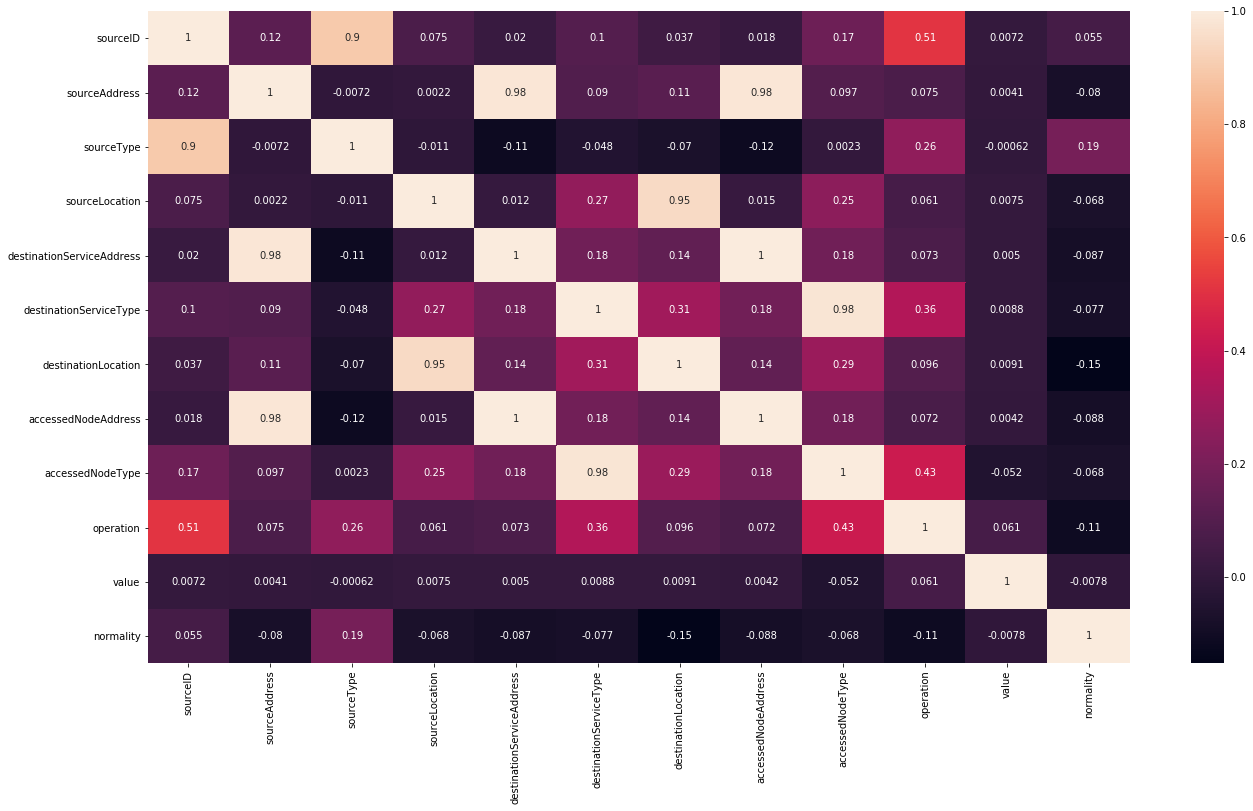

In [13]:
#plot correlation matrix by calling function correction_plot.
correlation_plot(std_enc_df)

### PCA Visualization

This helps us see the spread of data in 2-dimensional principle component space. The scatter plot shows the distribution of anomalies in data.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

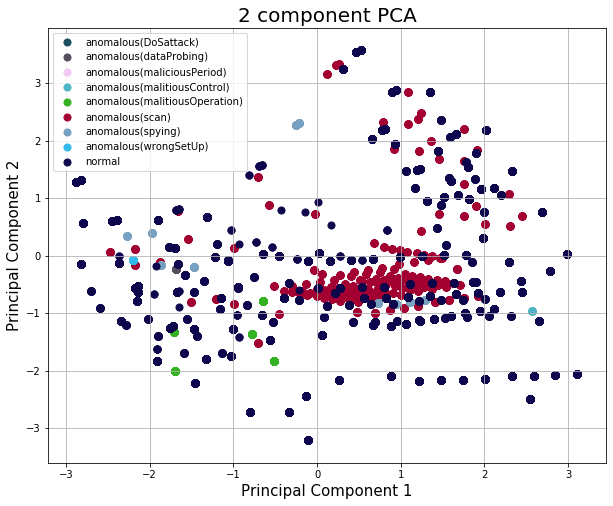

In [14]:
#by calling pca we get dataframe containing principal component 1 and principal component 2 along with target label we also get pca to 
#later use in plot function

principal_df,pca_=pca(features,target)

#colors of anomalies in this graph are assigned randomly everytime you call this function

pca_visualize(principal_df)

### Bi-Plot Visualization
This helps visualize 2d pca data with all labels(anomalies) and direction of maximum variance in data by arrow heads. The name on the arrow head represents feature in that direction. From the biplot drawn below we can see that the following features are important:

1. sourceID
2. sourceType
3. sourceLocation
4. operation
5. destinationLocation
6. accessNodeType
7. destinationServiceType

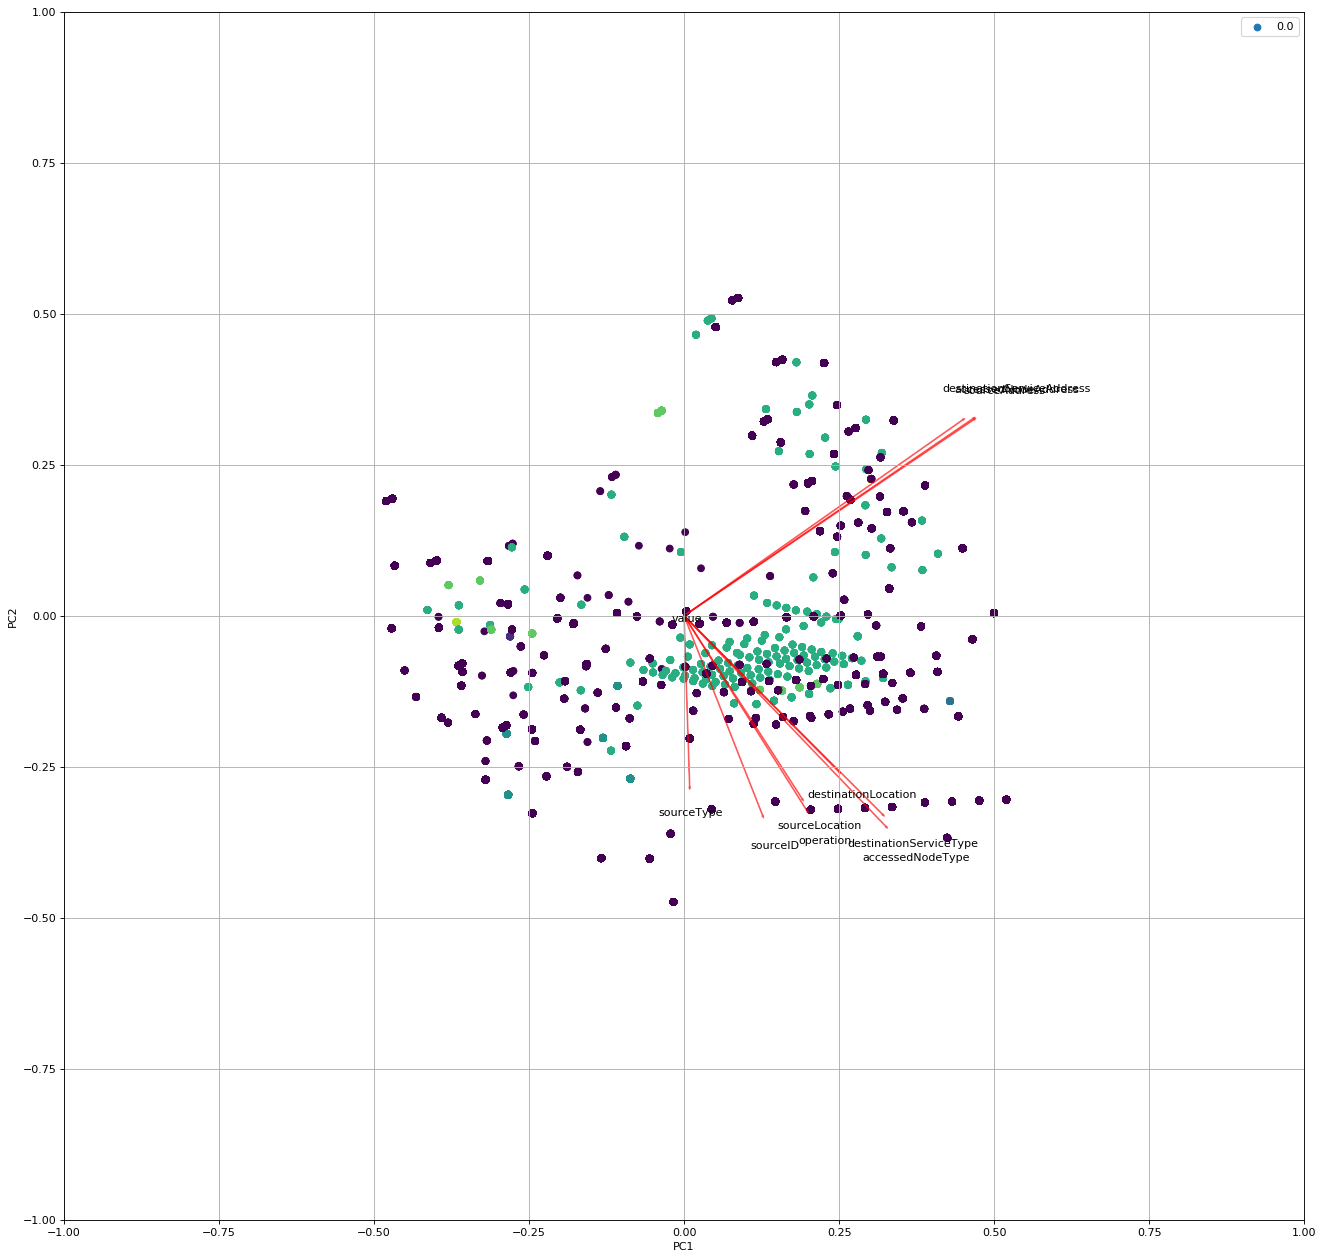

In [15]:
#Call the function. Use only the 2 PCs.
biplot(principal_df,np.transpose(pca_.components_),std_enc_df.columns,std_enc_df['normality'])


## Model Training and Validation

In [16]:

#split data and labels for training and testing purpose. we are giving principal components for training 

x_train,x_test,y_train,y_test=split_data(np.array(principal_df.drop('target',axis=1)),principal_df['target'].values,0.2)

In [17]:

#make dictionary of trained classifiers. we are training three different classifiers "Support Vector Machine (SVM)","Random Forest" and 
#"K Nearest Neighbour"

classifiers={}
classifiers['SVM']=train_svm(x_train,y_train)
classifiers['RF']=train_RandomForest(x_train,y_train)
classifiers['KNN']=train_KNN(x_train,y_train)

In [18]:

#we make two dictionaries. y_predicted for storing predicted labels on test data and accuracies dictionary to store accuracy values for 
#all classifiers and key value for all dictionaries are same

y_predicted={}
accuracies={}
for key in classifiers.keys():
    y_predicted[key]=classifiers[key].predict(x_test)
    accuracies[key]=metrics.accuracy_score(y_test,y_predicted[key])

In [19]:
for key in accuracies.keys():
    print('Validation accuracy of '+ key +': ' , accuracies[key])

Validation accuracy of SVM:  0.9697895552640992
Validation accuracy of RF:  0.9777632049600572
Validation accuracy of KNN:  0.97795695719566


In [67]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5, forward=True)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [68]:
cls = ['anomalous(DoSattack)', 'anomalous(dataProbing)',
       'anomalous(maliciousPeriod)', 'anomalous(malitiousControl)',
       'anomalous(malitiousOperation)', 'anomalous(scan)',
       'anomalous(spying)', 'anomalous(wrongSetUp)', 'normal']

Confusion matrix, without normalization
[[  426     0     0     0     0     0     0     0  1439]
 [    0     0     0     0     0     0     0     0     5]
 [    0     0     0     0     0     0     0     0    35]
 [    0     0     0     0     0     0     0     0     3]
 [    0     0     0     0     0     0     0     0   133]
 [    5     0     0     0     0     0     0     0   307]
 [    0     0     0     0     0     0     8     0    53]
 [    0     0     0     0     0     0     0     0    12]
 [   35     0     0     0     0     0     0     0 64635]]


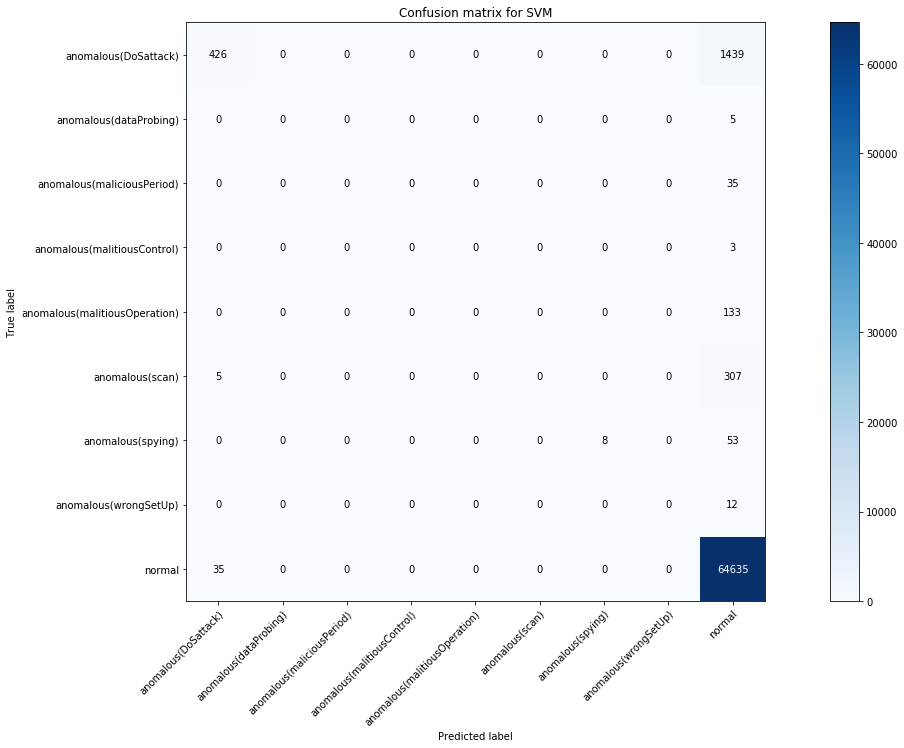

In [70]:
plot_confusion_matrix(y_test, y_predicted['SVM'], classes=cls,
                      title='Confusion matrix for SVM')

Confusion matrix, without normalization
[[  426     0     0     0     0     0     0     0  1439]
 [    0     5     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0    35]
 [    0     0     0     3     0     0     0     0     0]
 [    0     0     0     0   133     0     0     0     0]
 [    0     0     0     0     0   312     0     0     0]
 [    0     0     0     0     0     0    61     0     0]
 [    0     0     0     0     0     0     0    12     0]
 [   15     0     0     0     0     2     1     0 64652]]


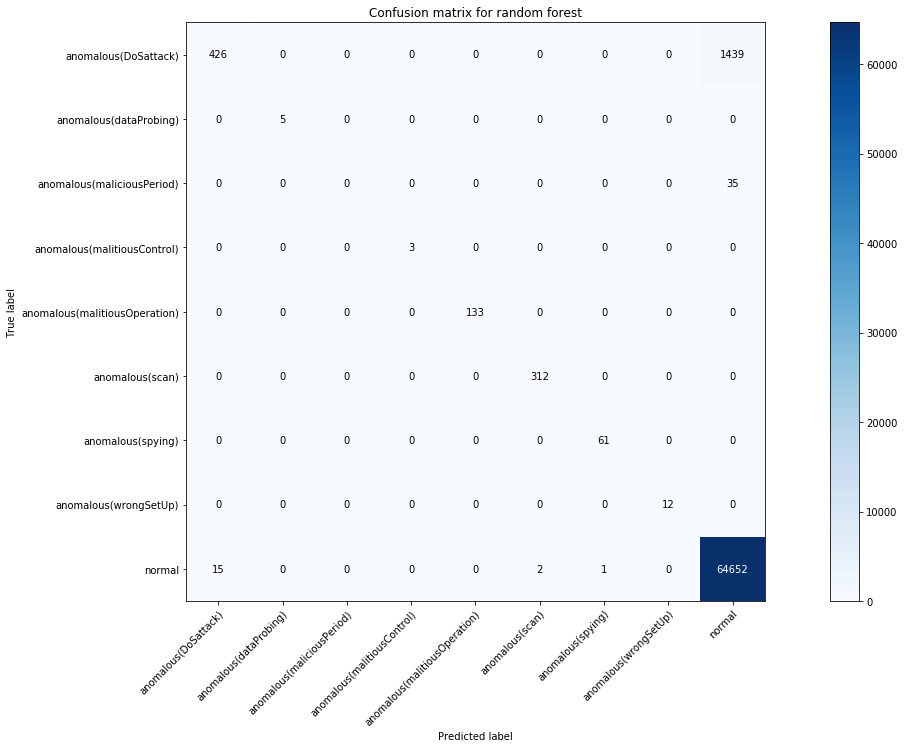

In [71]:
plot_confusion_matrix(y_test, y_predicted['RF'], classes=cls,
                      title='Confusion matrix for random forest')

Confusion matrix, without normalization
[[  426     0     0     0     0     0     0     0  1439]
 [    0     5     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0    35]
 [    0     0     0     3     0     0     0     0     0]
 [    0     0     0     0   133     0     0     0     0]
 [    0     0     0     0     0   312     0     0     0]
 [    0     0     0     0     0     0    61     0     0]
 [    0     0     0     0     0     0     0    12     0]
 [    1     0     0     0     0     3     1     0 64665]]


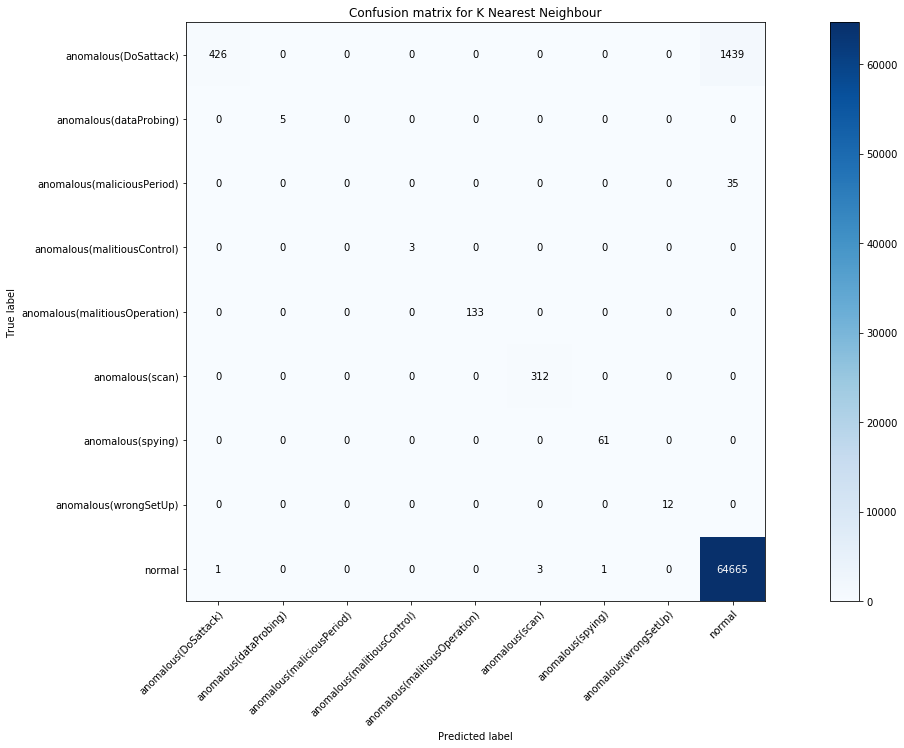

In [72]:
plot_confusion_matrix(y_test, y_predicted['KNN'], classes=cls,
                      title='Confusion matrix for K Nearest Neighbour')

In [87]:
cm = ConfusionMatrix(actual_vector=y_test, predict_vector=y_predicted['SVM']) # Create CM From Data

## F1 score for all classes

In [88]:
print('F1 score for all classes \n', cm.F1)

F1 score for all classes 
 {'anomalous(DoSattack)': 0.3655083655083655, 'anomalous(dataProbing)': 0.0, 'anomalous(maliciousPeriod)': 0.0, 'anomalous(malitiousControl)': 0.0, 'anomalous(malitiousOperation)': 0.0, 'anomalous(scan)': 0.0, 'anomalous(spying)': 0.2318840579710145, 'anomalous(wrongSetUp)': 0.0, 'normal': 0.9845992139658166}


## True Positive for all classes

In [81]:
print(cm.TP)

{'anomalous(DoSattack)': 426, 'anomalous(dataProbing)': 0, 'anomalous(maliciousPeriod)': 0, 'anomalous(malitiousControl)': 0, 'anomalous(malitiousOperation)': 0, 'anomalous(scan)': 0, 'anomalous(spying)': 8, 'anomalous(wrongSetUp)': 0, 'normal': 64635}


## True Negative for all classes

In [89]:
print(cm.TN)

{'anomalous(DoSattack)': 65191, 'anomalous(dataProbing)': 67091, 'anomalous(maliciousPeriod)': 67061, 'anomalous(malitiousControl)': 67093, 'anomalous(malitiousOperation)': 66963, 'anomalous(scan)': 66784, 'anomalous(spying)': 67035, 'anomalous(wrongSetUp)': 67084, 'normal': 439}


## False Positive for all classes

In [83]:
print(cm.FP)

{'anomalous(DoSattack)': 40, 'anomalous(dataProbing)': 0, 'anomalous(maliciousPeriod)': 0, 'anomalous(malitiousControl)': 0, 'anomalous(malitiousOperation)': 0, 'anomalous(scan)': 0, 'anomalous(spying)': 0, 'anomalous(wrongSetUp)': 0, 'normal': 1987}


## True Negative for all classes

true label: +ve and predicetd label: +ve --> TP
true label: -ve and predicted label: +ve --> FP
true label: -ve and predicted label: -ve --> TN
true label: +ve and predicted label: -ve --> FN

accuracy = total correct classifications / total classifications

precision = TP / TP + FP (ratio of correctly classified positive points over total classified positive points)

recall = TP / TP + FN (ration of correctly classified positive points over total positive data points)

F1 score = (TP + FP) / (TP + FP + TN + FN) (ratio of total positive classifications over all classifications)

In [84]:
print(cm.FN)

{'anomalous(DoSattack)': 1439, 'anomalous(dataProbing)': 5, 'anomalous(maliciousPeriod)': 35, 'anomalous(malitiousControl)': 3, 'anomalous(malitiousOperation)': 133, 'anomalous(scan)': 312, 'anomalous(spying)': 53, 'anomalous(wrongSetUp)': 12, 'normal': 35}


## Explaination for TP, FP, FN, TN

![alt text](tfnf.png "Title")